# Distribution of cosine distance for minimal syntax pairs

In [1]:
import sys
sys.path.append('../')

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
import os, sys, time, re
import matplotlib.pyplot as plt
import random
import pickle
from scipy.spatial.distance import cosine
import seaborn as sns

import src.sent_encoder

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load sentence pairs

"Targeted Syntactic Evaluation of Language Models" by Marvin and Linzen (2018).
https://github.com/BeckyMarvin/LM_syneval

Or use the ones generated by CheckList.

In [2]:
with open('../data/sents.pkl', 'rb') as f:
  data = pickle.load(f)
  data = list(data)

In [3]:
# https://wortschatz.uni-leipzig.de/en/download/english
# Wikipedia, 2016, 10K sentences
with open('../data/leipzig_wikipedia.txt') as f:
  wiki_sents = f.read().split('\n')[:-1]

In [4]:
len(data)

321

In [5]:
data[:5]

[('The buyer sold the seller a gun.', 'The buyer sold a gun to the seller.'),
 ('The girl took the boy a bus.', 'The girl took a bus to the boy.'),
 ('The attacker sent the victim a message.',
  'The attacker sent a message to the victim.'),
 ('The boy brought the girl a toy.', 'The boy brought a toy to the girl.'),
 ('The victim sent the suspect a note.',
  'The victim sent a note to the suspect.')]

In [6]:
wiki_sents[:5]

['10 Years of Time Team presented a round-up of what has happened in Time Team over the past 10 years and what they expect to happen in the future.',
 '13 October 1962 marked the initial working session of the Council.',
 "1945 Overhauled, Indianapolis joined Vice Admiral Marc A. Mitscher 's fast carrier task force on 14 February 1945.",
 '1965 was also the deadline for AAFSS selection, but the program would become stuck in technical difficulties and political bickering.',
 '1969 to 1982 The British Telecom "T" symbol logo, used from 1980 to 1991 In 1977, the Carter Committee Report recommended a further division of the two main services and for their relocation under two individual corporations.']

In [7]:
enc = src.sent_encoder.SentEncoder()

## Wikipedia as control sentences

In [8]:
wiki_vecs = []
for i in range(300):
  s1 = random.choice(wiki_sents)
  s2 = random.choice(wiki_sents)
  if s1 == s2: continue
  wiki_vecs.append(enc.evaluate_contextual_diff((s1, s2)).detach().numpy())
wiki_vecs = np.stack(wiki_vecs)

In [9]:
wiki_cosine_distances = []
for i in range(len(wiki_vecs)):
  for j in range(i+1, len(wiki_vecs)):
    wiki_cosine_distances.append(cosine(wiki_vecs[i,:], wiki_vecs[j,:]))

## Evaluate and plot

In [10]:
vecs = np.stack([enc.evaluate_contextual_diff(pair).detach().numpy() for pair in data])

In [11]:
cosine_distances = []
for i in range(len(vecs)):
  for j in range(i+1, len(vecs)):
    cosine_distances.append(pd.Series({
      'cosdist': cosine(vecs[i,:], vecs[j,:]),
      'sent1a': data[i][0],
      'sent1b': data[i][1],
      'sent2a': data[j][0],
      'sent2b': data[j][1],
    }))

In [12]:
cosine_distances = pd.DataFrame(cosine_distances)

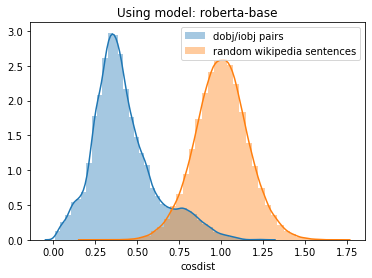

In [14]:
model_name = 'roberta-base'
sns.distplot(cosine_distances.cosdist, bins=40, label='dobj/iobj pairs')
sns.distplot(wiki_cosine_distances, bins=40, label='random wikipedia sentences')
plt.title(f"Using model: {model_name}")
plt.legend()
plt.show()

In [15]:
np.mean(cosine_distances.cosdist)

0.4196268187715893

In [16]:
np.mean(wiki_cosine_distances)

1.0005396569258687

## Inspect most similar and dissimilar pairs

Some sentences seem questionable: "The man took the dog a walk".

In [17]:
cosine_distances.sort_values('cosdist').head(5)

,cosdist,sent1a,sent1b,sent2a,sent2b
47975,0.010016,The assailant took the victim a knife.,The assailant took a knife to the victim.,The suspect took the victim a knife.,The suspect took a knife to the victim.
28992,0.012441,The mother sold the boy a bicycle.,The mother sold a bicycle to the boy.,The father sold the boy a bicycle.,The father sold a bicycle to the boy.
39659,0.013216,The gunman brought the victim a knife.,The gunman brought a knife to the victim.,The shooter brought the victim a knife.,The shooter brought a knife to the victim.
50591,0.013900,The defendant sold the victim a handgun.,The defendant sold a handgun to the victim.,The defendant sold the victim a firearm.,The defendant sold a firearm to the victim.
10037,0.014434,The shooter showed the victim a gun.,The shooter showed a gun to the victim.,The gunman showed the victim a gun.,The gunman showed a gun to the victim.


In [18]:
cosine_distances.sort_values('cosdist', ascending=False).head(5)

,cosdist,sent1a,sent1b,sent2a,sent2b
46640,1.262826,The man took the dog a walk.,The man took a walk to the dog.,The suspect took the victim a knife.,The suspect took a knife to the victim.
2468,1.253903,The owner took the dog a walk.,The owner took a walk to the dog.,The suspect took the victim a knife.,The suspect took a knife to the victim.
46621,1.247552,The man took the dog a walk.,The man took a walk to the dog.,The assailant took the victim a knife.,The assailant took a knife to the victim.
2260,1.242740,The owner took the dog a walk.,The owner took a walk to the dog.,The suspect took the officer a gun.,The suspect took a gun to the officer.
42385,1.240813,The boy took the dog a walk.,The boy took a walk to the dog.,The suspect took the victim a knife.,The suspect took a knife to the victim.
